First cell is for both branches stop growing upon collision

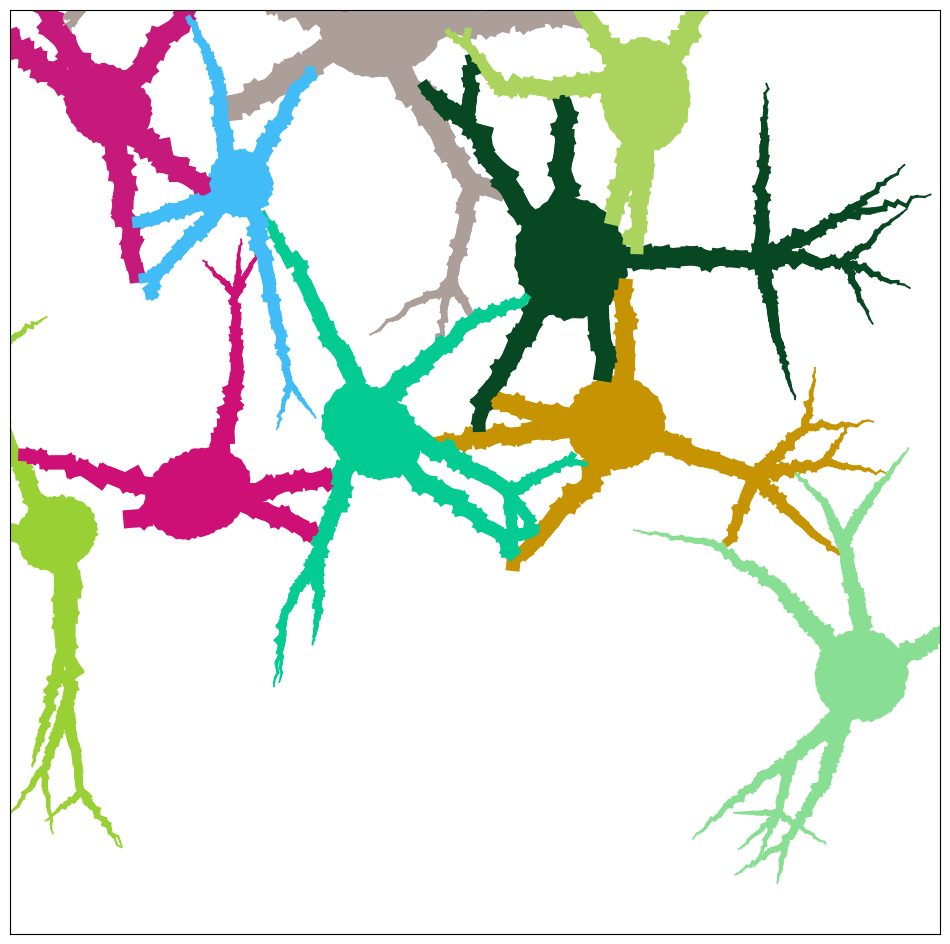

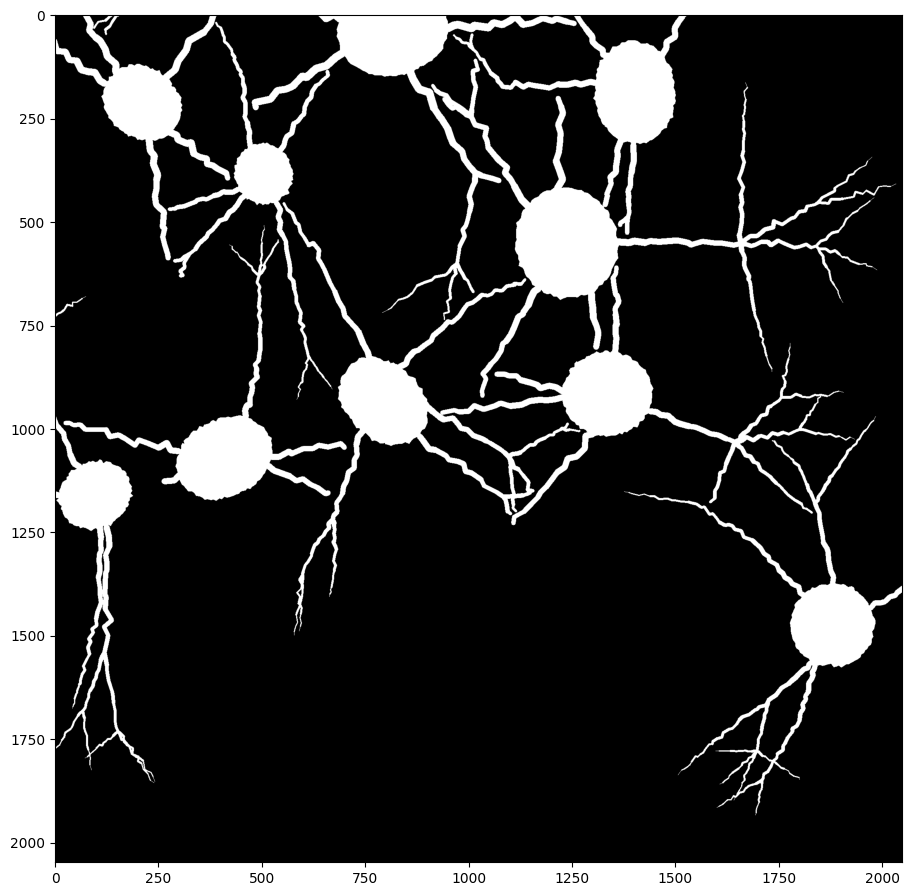

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

class Soma:
    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[1]

        return x_soma, y_soma

    def draw(self, color):
        plt.fill(self.x_soma, self.y_soma, color=color)

    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)
        return mask

class Dendrite:
    def __init__(
        self,
        soma,
        depth,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
    ):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r ** i for i in range(self.depth))

        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r ** i

        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(int)

        random_offsets = np.random.randint(
            -num_soma_points // (100 // self.n_primary_dendrites // 1.5),
            (100 // self.n_primary_dendrites // 1.5) + 1,
            size=self.n_primary_dendrites,
        )
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = 0.02
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)

    def _calculate_thickness(self, distance_from_start, segment_length):
        # Calculate proportions
        proportion_start = 1 - (distance_from_start / self.total_length)
        proportion_end = 1 - ((distance_from_start + segment_length) / self.total_length)

        # Ensure proportions are within [0, 1]
        proportion_start = np.clip(proportion_start, 0, 1)
        proportion_end = np.clip(proportion_end, 0, 1)

        # Calculate thicknesses
        thickness_at_start = self.initial_thickness * (proportion_start) ** (1 / self.D)
        thickness_at_end = self.initial_thickness * (proportion_end) ** (1 / self.D)

        # Ensure thicknesses are at least 1
        thickness_at_start = max(thickness_at_start, 1)
        thickness_at_end = max(thickness_at_end, 1)

        return thickness_at_start, thickness_at_end

    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)

        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys

        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2

        return perturb_xs, perturb_ys

    def _grow_branch(self, x, y, angle, remaining_depth):
        if remaining_depth == 0:
            return None, []

        branch_length = self.branch_lengths[self.depth - remaining_depth]
        sum_length = sum(self.branch_lengths[:self.depth - remaining_depth])
        thickness_start, thickness_end = self._calculate_thickness(sum_length, branch_length)

        # Apply randomness and weaving
        if self.weave_type == 'Gauss':
            branch_length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            branch_length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)

        # Generate incremental points along the branch
        num_steps = int(branch_length)
        xs = [x]
        ys = [y]
        for step in range(1, num_steps + 1):
            delta = step / num_steps
            xs.append(x + delta * branch_length * np.cos(angle))
            ys.append(y + delta * branch_length * np.sin(angle))

        # Apply curviness if needed
        weave_xs, weave_ys = self.intra_branch_weave(xs[0], ys[0], xs[-1], ys[-1], branch_length)

        branch_data = {
            'points': np.array([weave_xs, weave_ys]),
            'length': branch_length,
            'depth': self.depth - remaining_depth,
            'thickness_start': thickness_start,
            'thickness_end': thickness_end
        }

        # Prepare new branches for potential growth
        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []
        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)
            new_branches.append(((weave_xs[-1], weave_ys[-1]), new_angle))

        return branch_data, new_branches

    def draw(self, color):
        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))

            for i in range(len(points[0]) - 1):
                plt.plot(points[0][i:i + 2], points[1][i:i + 2], color=color, linewidth=thicknesses[i])

    def create_dendrite_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(mask, tuple(coordinates[i]), tuple(coordinates[i + 1]), 1, thickness=thicknesses[i])

        return mask

class Neuron:
    def __init__(
        self,
        position,
        depth,
        mean_soma_radius,
        std_soma_radius,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
        network=None,
        neuron_id=None,
    ):
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.soma_mask = self.soma.create_binary_mask(size=(network.height, network.width))
        self.dendrite = Dendrite(
            self.soma,
            depth,
            D,
            branch_angle,
            mean_branches,
            weave_type,
            randomness,
            curviness,
            curviness_magnitude,
            n_primary_dendrites,
        )
        self.dendrite_mask = np.zeros((network.height, network.width), dtype=np.uint8)
        self.neuron_mask = None
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.start_points = None
        self.branch_ends = []
        self.is_growing = True  # Flag to indicate if the neuron is still growing

    def generate_start_points(self):
        self.start_points = self.dendrite._generate_dendrite_start_points()
        self.branch_ends = [
            (point, np.arctan2(point[1] - self.position[1], point[0] - self.position[0])) for point in self.start_points
        ]

    def prepare_next_layer(self):
        """
        Prepare the proposed branches for the next layer without updating the dendrite mask.
        """
        if self.current_depth >= self.dendrite.depth or not self.branch_ends:
            self.is_growing = False
            return []

        proposed_branches = []

        for start_point, angle in self.branch_ends:
            branch_data, new_branches = self.dendrite._grow_branch(
                start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth
            )

            if branch_data is not None:
                proposed_branches.append({
                    'branch_data': branch_data,
                    'start_point': start_point,
                    'new_branches': new_branches  # Include new branch ends
                })

        return proposed_branches

    def add_branches(self, accepted_branches):
        """
        Add the accepted branches to the dendrite list, update the dendrite mask, and update branch ends.
        """
        new_branch_ends = []

        for branch_info in accepted_branches:
            branch_data = branch_info['branch_data']
            start_point = branch_info['start_point']
            points = branch_data['points']
            new_branches = branch_info['new_branches']

            # Update dendrite list
            self.dendrite.dendrite_list.append(branch_data)

            # Update dendrite mask
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            thickness_start = branch_data['thickness_start']
            thickness_end = branch_data['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            for i in range(len(coordinates) - 1):
                cv2.line(
                    self.dendrite_mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=thicknesses[i],
                )

            # Update branch ends with new branches from accepted branches
            new_branch_ends.extend(new_branches)

        # Update self.branch_ends for the next layer
        self.branch_ends = new_branch_ends

    def draw(self, color):
        self.soma.draw(color)
        self.dendrite.draw(color)

    def generate_binary_mask(self):
        soma_mask = self.soma_mask
        dendrite_mask = self.dendrite_mask
        self.neuron_mask = np.logical_or(soma_mask, dendrite_mask).astype(np.uint8)
        return self.neuron_mask

class Network:
    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id

    def _seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap.
        """
        for neuron_index in range(self.num_neurons):
            max_attempts = 100  # Limit the number of attempts to avoid infinite loops
            attempts = 0

            while attempts < max_attempts:
                # Generate a random position for the neuron
                position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
                neuron_id = f"{self.network_id}_neuron_{neuron_index}"

                # Create a new neuron object
                neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)

                # Create a binary mask of the soma
                new_soma_mask = neuron.soma.create_binary_mask(size=(self.height, self.width))

                # Check if there is an overlap with any existing somas
                overlap = np.any(np.logical_and(self.somas_mask, new_soma_mask))

                if not overlap:
                    # If there is no overlap, add the neuron to the network
                    self.neurons.append(neuron)
                    self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
                    neuron.generate_start_points()
                    break  # Exit the while loop and move to the next neuron

                attempts += 1

            if attempts == max_attempts:
                print(f"Warning: Could not place neuron {neuron_index} without overlap after {max_attempts} attempts.")

    def grow_network(self):
        growing = True
        while growing:
            growing = False
            # Collect proposed branches from all neurons
            all_proposed_branches = {}
            for neuron in self.neurons:
                if neuron.is_growing:
                    proposed_branches = neuron.prepare_next_layer()
                    if proposed_branches:
                        all_proposed_branches[neuron] = proposed_branches
                        growing = True
                    else:
                        neuron.is_growing = False

            # Collision detection and acceptance of branches
            for neuron, branches in all_proposed_branches.items():
                accepted_branches = []
                # Exclude own dendrites from existing mask
                existing_mask = np.logical_and(self.network_dendrites_mask, np.logical_not(neuron.dendrite_mask)).astype(np.uint8)

                # Exclude own soma from other somas mask
                other_somas_mask = np.logical_and(self.somas_mask, np.logical_not(neuron.soma_mask)).astype(np.uint8)

                # Combine proposed masks from other neurons
                other_neurons_masks = np.zeros((self.height, self.width), dtype=np.uint8)
                for other_neuron, other_branches in all_proposed_branches.items():
                    if other_neuron != neuron:
                        mask = np.zeros((self.height, self.width), dtype=np.uint8)
                        for branch_info in other_branches:
                            branch_data = branch_info['branch_data']
                            points = branch_data['points']
                            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
                            thickness_start = branch_data['thickness_start']
                            thickness_end = branch_data['thickness_end']
                            thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
                            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
                            for i in range(len(coordinates) - 1):
                                cv2.line(
                                    mask,
                                    tuple(coordinates[i]),
                                    tuple(coordinates[i + 1]),
                                    1,
                                    thickness=thicknesses[i],
                                )
                        other_neurons_masks = np.logical_or(other_neurons_masks, mask).astype(np.uint8)

                for branch_info in branches:
                    branch_data = branch_info['branch_data']
                    points = branch_data['points']
                    coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
                    thickness_start = branch_data['thickness_start']
                    thickness_end = branch_data['thickness_end']
                    thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
                    thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)

                    branch_mask = np.zeros((self.height, self.width), dtype=np.uint8)
                    collision_detected = False
                    collision_index = None

                    for i in range(len(coordinates) - 1):
                        # Draw the current segment
                        cv2.line(
                            branch_mask,
                            tuple(coordinates[i]),
                            tuple(coordinates[i + 1]),
                            1,
                            thickness=thicknesses[i],
                        )

                        # Check for collisions
                        overlap_existing = np.logical_and(existing_mask, branch_mask)
                        overlap_proposed = np.logical_and(other_neurons_masks, branch_mask)
                        overlap_somas = np.logical_and(other_somas_mask, branch_mask)

                        if np.any(overlap_existing) or np.any(overlap_proposed) or np.any(overlap_somas):
                            # Collision detected at this segment
                            collision_detected = True
                            collision_index = i
                            break

                    if collision_detected:
                        # Truncate the branch up to the collision point
                        if collision_index == 0:
                            # Collision at the start; discard the branch
                            continue
                        branch_data['points'] = branch_data['points'][:, :collision_index + 1]
                        branch_data['length'] = branch_data['length'] * (collision_index / (len(coordinates) - 1))
                        branch_data['thickness_end'] = thicknesses[collision_index]
                        # Do not add new branches from this truncated branch
                        branch_info['new_branches'] = []
                        # Update the mask up to the collision point
                        branch_mask = np.zeros((self.height, self.width), dtype=np.uint8)
                        for j in range(collision_index):
                            cv2.line(
                                branch_mask,
                                tuple(coordinates[j]),
                                tuple(coordinates[j + 1]),
                                1,
                                thickness=thicknesses[j],
                            )
                        accepted_branches.append(branch_info)
                    else:
                        # No collision detected; accept the entire branch
                        accepted_branches.append(branch_info)

                # Add accepted branches to the neuron and update branch ends
                neuron.add_branches(accepted_branches)

            # Update the network dendrite mask with all accepted branches
            self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
            for neuron in self.neurons:
                self.network_dendrites_mask = np.logical_or(
                    self.network_dendrites_mask, neuron.dendrite_mask
                ).astype(np.uint8)

            # Increment the current depth for all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    neuron.current_depth += 1

    def generate_binary_mask(self):
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

        for neuron in self.neurons:
            color = np.random.rand(3,)
            neuron.draw(color=color)

        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        data = {
            f'{self.network_id}_network_mask': [self.network_mask]
        }
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df

# Parameters
network_width = 2048
network_height = 2048
num_neurons = 10

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 3,
    'mean_soma_radius': 100,
    'std_soma_radius': 15,
    'D': 1.5,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.2,
    'curviness': 'Gauss',
    'curviness_magnitude': 1.5,
    'n_primary_dendrites': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params, 'nn0')
network._seed_neurons()
network.grow_network()

# Draw the network
network.draw()

network_mask = network.generate_binary_mask()
network_mask_flipped = np.flipud(network_mask)
plt.figure(figsize=(11, 11))
plt.imshow(network_mask_flipped, cmap='gray')
plt.show()

nn0_df = network.create_dataframe()
#print(nn0_df)


Below cell is for only shorter of two branches continues growing upon collision. Longer one stops.

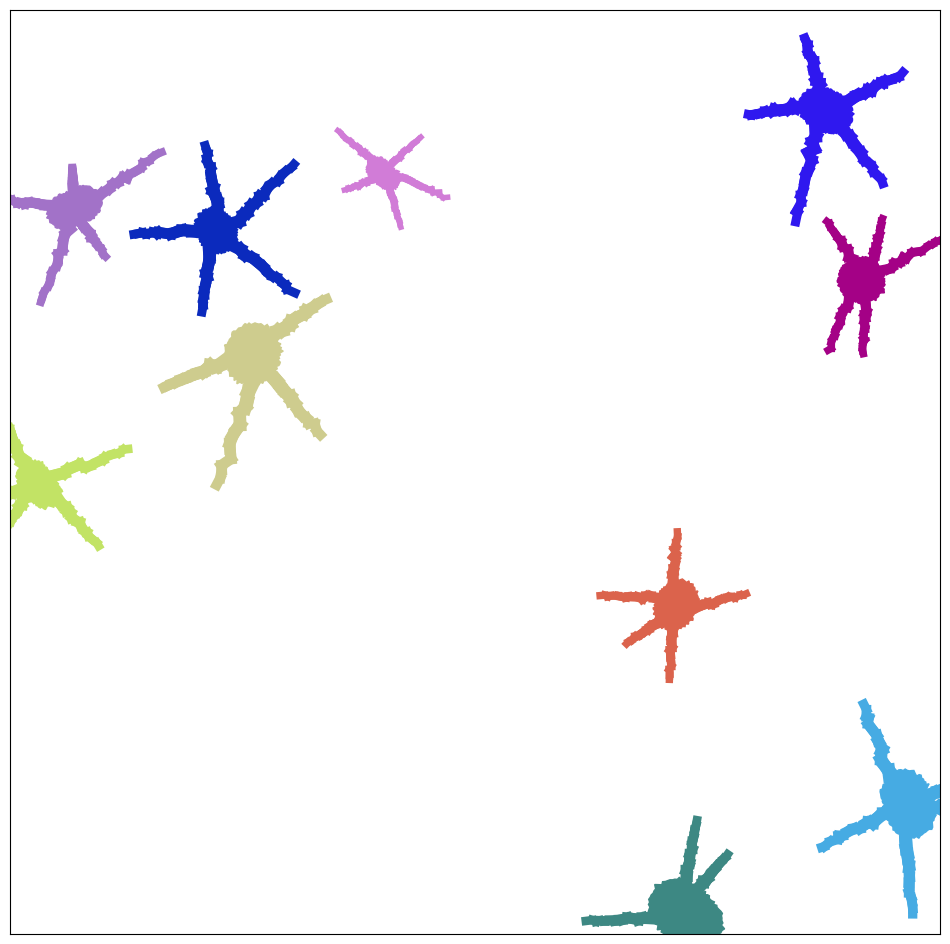

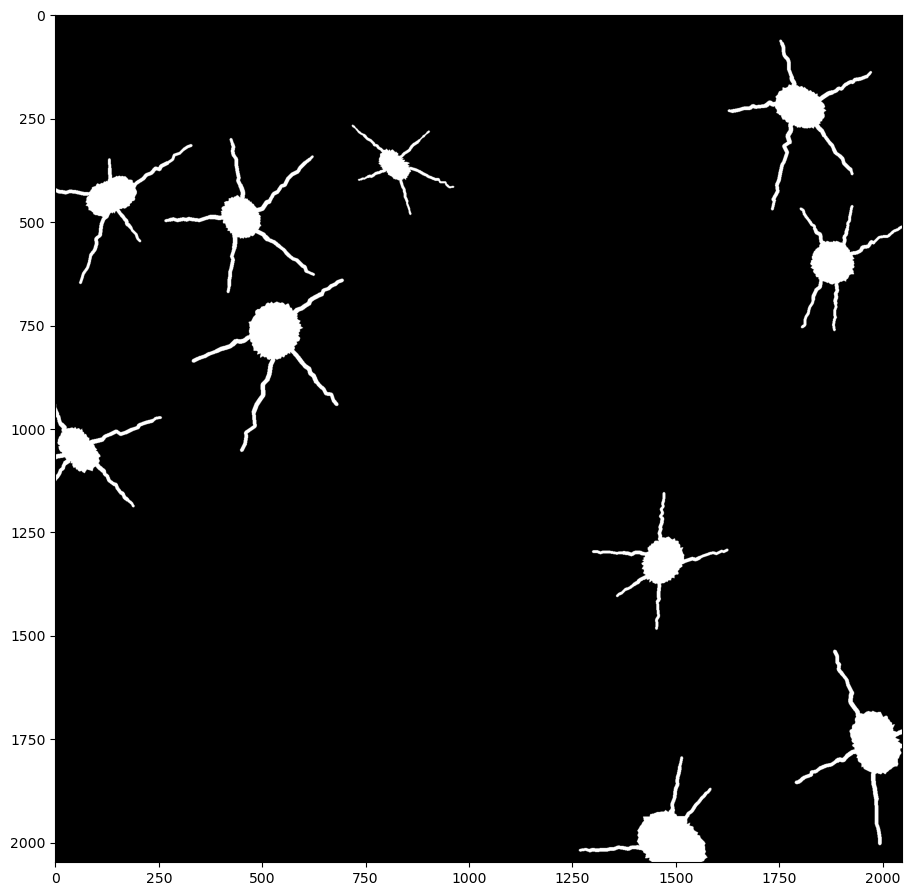

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

class Soma:
    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[1]

        return x_soma, y_soma

    def draw(self, color):
        plt.fill(self.x_soma, self.y_soma, color=color)

    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)
        return mask

class Dendrite:
    def __init__(
        self,
        soma,
        depth,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
    ):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r ** i for i in range(self.depth))

        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r ** i

        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(int)

        random_offsets = np.random.randint(
            -num_soma_points // (100 // self.n_primary_dendrites // 1.5),
            (100 // self.n_primary_dendrites // 1.5) + 1,
            size=self.n_primary_dendrites,
        )
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = 0.02
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)

    def _calculate_thickness(self, distance_from_start, segment_length):
        # Calculate proportions
        proportion_start = 1 - (distance_from_start / self.total_length)
        proportion_end = 1 - ((distance_from_start + segment_length) / self.total_length)

        # Ensure proportions are within [0, 1]
        proportion_start = np.clip(proportion_start, 0, 1)
        proportion_end = np.clip(proportion_end, 0, 1)

        # Calculate thicknesses
        thickness_at_start = self.initial_thickness * (proportion_start) ** (1 / self.D)
        thickness_at_end = self.initial_thickness * (proportion_end) ** (1 / self.D)

        # Ensure thicknesses are at least 1
        thickness_at_start = max(thickness_at_start, 1)
        thickness_at_end = max(thickness_at_end, 1)

        return thickness_at_start, thickness_at_end

    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)

        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys

        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2

        return perturb_xs, perturb_ys

    def _grow_branch(self, x, y, angle, remaining_depth, branch_id):
        if remaining_depth == 0:
            return None, []

        branch_length = self.branch_lengths[self.depth - remaining_depth]
        sum_length = sum(self.branch_lengths[:self.depth - remaining_depth])
        thickness_start, thickness_end = self._calculate_thickness(sum_length, branch_length)

        # Apply randomness and weaving
        if self.weave_type == 'Gauss':
            branch_length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            branch_length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)

        # Generate incremental points along the branch
        num_steps = int(branch_length)
        xs = [x]
        ys = [y]
        for step in range(1, num_steps + 1):
            delta = step / num_steps
            xs.append(x + delta * branch_length * np.cos(angle))
            ys.append(y + delta * branch_length * np.sin(angle))

        # Apply curviness if needed
        weave_xs, weave_ys = self.intra_branch_weave(xs[0], ys[0], xs[-1], ys[-1], branch_length)

        branch_data = {
            'points': np.array([weave_xs, weave_ys]),
            'length': branch_length,
            'depth': self.depth - remaining_depth,
            'thickness_start': thickness_start,
            'thickness_end': thickness_end,
            'branch_id': branch_id,  # Assign branch ID
            'neuron_id': self.soma.position  # Use soma position as neuron ID
        }

        # Prepare new branches for potential growth
        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []
        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)
            new_branches.append(((weave_xs[-1], weave_ys[-1]), new_angle))

        return branch_data, new_branches

    def draw(self, color):
        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))

            for i in range(len(points[0]) - 1):
                plt.plot(points[0][i:i + 2], points[1][i:i + 2], color=color, linewidth=thicknesses[i])

    def create_dendrite_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch['points']
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(mask, tuple(coordinates[i]), tuple(coordinates[i + 1]), 1, thickness=thicknesses[i])

        return mask

class Neuron:
    def __init__(
        self,
        position,
        depth,
        mean_soma_radius,
        std_soma_radius,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
        network=None,
        neuron_id=None,
    ):
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.soma_mask = self.soma.create_binary_mask(size=(network.height, network.width))
        self.dendrite = Dendrite(
            self.soma,
            depth,
            D,
            branch_angle,
            mean_branches,
            weave_type,
            randomness,
            curviness,
            curviness_magnitude,
            n_primary_dendrites,
        )
        self.dendrite_mask = np.zeros((network.height, network.width), dtype=np.uint8)
        self.neuron_mask = None
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.start_points = None
        self.branch_ends = []
        self.is_growing = True  # Flag to indicate if the neuron is still growing
        self.branch_counter = 0  # To assign unique IDs to branches

    def generate_start_points(self):
        self.start_points = self.dendrite._generate_dendrite_start_points()
        self.branch_ends = [
            (point, np.arctan2(point[1] - self.position[1], point[0] - self.position[0])) for point in self.start_points
        ]

    def prepare_next_layer(self):
        """
        Prepare the proposed branches for the next layer without updating the dendrite mask.
        """
        if self.current_depth >= self.dendrite.depth or not self.branch_ends:
            self.is_growing = False
            return []

        proposed_branches = []

        for start_point, angle in self.branch_ends:
            self.branch_counter += 1
            branch_id = (self.neuron_id, self.branch_counter)
            branch_data, new_branches = self.dendrite._grow_branch(
                start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth, branch_id
            )

            if branch_data is not None:
                proposed_branches.append({
                    'branch_data': branch_data,
                    'start_point': start_point,
                    'new_branches': new_branches  # Include new branch ends
                })

        return proposed_branches

    def add_branches(self, accepted_branches):
        """
        Add the accepted branches to the dendrite list, update the dendrite mask, and update branch ends.
        """
        new_branch_ends = []

        for branch_info in accepted_branches:
            branch_data = branch_info['branch_data']
            start_point = branch_info['start_point']
            points = branch_data['points']
            new_branches = branch_info['new_branches']

            # Update dendrite list
            self.dendrite.dendrite_list.append(branch_data)

            # Update dendrite mask
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            thickness_start = branch_data['thickness_start']
            thickness_end = branch_data['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            for i in range(len(coordinates) - 1):
                cv2.line(
                    self.dendrite_mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=thicknesses[i],
                )

            # Update branch ends with new branches from accepted branches
            new_branch_ends.extend(new_branches)

        # Update self.branch_ends for the next layer
        self.branch_ends = new_branch_ends

    def draw(self, color):
        self.soma.draw(color)
        self.dendrite.draw(color)

    def generate_binary_mask(self):
        soma_mask = self.soma_mask
        dendrite_mask = self.dendrite_mask
        self.neuron_mask = np.logical_or(soma_mask, dendrite_mask).astype(np.uint8)
        return self.neuron_mask

class Network:
    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id

    def _seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap.
        """
        for neuron_index in range(self.num_neurons):
            max_attempts = 100  # Limit the number of attempts to avoid infinite loops
            attempts = 0

            while attempts < max_attempts:
                # Generate a random position for the neuron
                position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
                neuron_id = f"{self.network_id}_neuron_{neuron_index}"

                # Create a new neuron object
                neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)

                # Create a binary mask of the soma
                new_soma_mask = neuron.soma.create_binary_mask(size=(self.height, self.width))

                # Check if there is an overlap with any existing somas
                overlap = np.any(np.logical_and(self.somas_mask, new_soma_mask))

                if not overlap:
                    # If there is no overlap, add the neuron to the network
                    self.neurons.append(neuron)
                    self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
                    neuron.generate_start_points()
                    break  # Exit the while loop and move to the next neuron

                attempts += 1

            if attempts == max_attempts:
                print(f"Warning: Could not place neuron {neuron_index} without overlap after {max_attempts} attempts.")

    def grow_network(self):
        growing = True
        while growing:
            growing = False
            # Collect proposed branches from all neurons
            all_proposed_branches = []
            accepted_branches = []
            for neuron in self.neurons:
                if neuron.is_growing:
                    proposed_branches = neuron.prepare_next_layer()
                    if proposed_branches:
                        for branch_info in proposed_branches:
                            branch_data = branch_info['branch_data']
                            all_proposed_branches.append({
                                'neuron': neuron,
                                'branch_info': branch_info,
                                'length': branch_data['length'],
                                'branch_id': branch_data['branch_id']
                            })
                        growing = True
                    else:
                        neuron.is_growing = False

            # Sort all proposed branches by length (shortest first)
            all_proposed_branches.sort(key=lambda x: x['length'])

            # Process branches in order
            for branch_entry in all_proposed_branches:
                neuron = branch_entry['neuron']
                branch_info = branch_entry['branch_info']
                branch_data = branch_info['branch_data']
                branch_id = branch_data['branch_id']

                # Create a mask for the branch
                points = branch_data['points']
                coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
                thickness_start = branch_data['thickness_start']
                thickness_end = branch_data['thickness_end']
                thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
                thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)

                branch_mask = np.zeros((self.height, self.width), dtype=np.uint8)
                for i in range(len(coordinates) - 1):
                    cv2.line(
                        branch_mask,
                        tuple(coordinates[i]),
                        tuple(coordinates[i + 1]),
                        1,
                        thickness=thicknesses[i],
                    )

                # Exclude own soma from collision detection
                other_somas_mask = np.logical_and(self.somas_mask, np.logical_not(neuron.soma_mask)).astype(np.uint8)

                existing_structures = np.logical_or(
                    self.network_dendrites_mask, other_somas_mask
                ).astype(np.uint8)

                collision = np.any(np.logical_and(existing_structures, branch_mask))

                if not collision:
                    # No collision, accept the branch
                    neuron.add_branches([branch_info])
                    self.network_dendrites_mask = np.logical_or(
                        self.network_dendrites_mask, neuron.dendrite_mask
                    ).astype(np.uint8)
                    accepted_branches.append({
                        'neuron': neuron,
                        'branch_info': branch_info,
                        'length': branch_entry['length'],
                        'branch_mask': branch_mask
                    })
                else:
                    # Collision detected, need to check with accepted branches
                    overlapping_pixels = np.logical_and(existing_structures, branch_mask)
                    collision_with_self = np.any(np.logical_and(neuron.dendrite_mask, branch_mask))
                    if collision_with_self:
                        # Collision with self, stop the branch
                        continue

                    # Find the colliding branch
                    colliding_branch = None
                    for accepted_branch in accepted_branches:
                        accepted_branch_mask = accepted_branch['branch_mask']
                        if np.any(np.logical_and(accepted_branch_mask, branch_mask)):
                            colliding_branch = accepted_branch
                            break

                    if colliding_branch:
                        # Compare lengths
                        if branch_entry['length'] < colliding_branch['length']:
                            # Shorter branch continues, longer branch stops
                            # Remove longer branch from network
                            colliding_neuron = colliding_branch['neuron']
                            colliding_neuron.dendrite.dendrite_list.remove(colliding_branch['branch_info']['branch_data'])
                            colliding_neuron.dendrite_mask = self._recompute_dendrite_mask(colliding_neuron)
                            self.network_dendrites_mask = self._recompute_network_dendrite_mask()
                            # Accept the shorter branch
                            neuron.add_branches([branch_info])
                            self.network_dendrites_mask = np.logical_or(
                                self.network_dendrites_mask, neuron.dendrite_mask
                            ).astype(np.uint8)
                            accepted_branches.append({
                                'neuron': neuron,
                                'branch_info': branch_info,
                                'length': branch_entry['length'],
                                'branch_mask': branch_mask
                            })
                        else:
                            # Longer branch stops
                            continue
                    else:
                        # Collision with existing structures (e.g., soma)
                        continue

            # Increment the current depth for all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    neuron.current_depth += 1

    def _recompute_dendrite_mask(self, neuron):
        """
        Recompute the dendrite mask for a neuron after removing branches.
        """
        dendrite_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for branch in neuron.dendrite.dendrite_list:
            points = branch['points']
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            thickness_start = branch['thickness_start']
            thickness_end = branch['thickness_end']
            thicknesses = np.linspace(thickness_start, thickness_end, len(coordinates))
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            for i in range(len(coordinates) - 1):
                cv2.line(
                    dendrite_mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=thicknesses[i],
                )
        return dendrite_mask

    def _recompute_network_dendrite_mask(self):
        """
        Recompute the network dendrite mask after changes.
        """
        network_dendrites_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            network_dendrites_mask = np.logical_or(
                network_dendrites_mask, neuron.dendrite_mask
            ).astype(np.uint8)
        return network_dendrites_mask

    def generate_binary_mask(self):
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])

        for neuron in self.neurons:
            color = np.random.rand(3,)
            neuron.draw(color=color)

        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        data = {
            f'{self.network_id}_network_mask': [self.network_mask]
        }
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df

# Parameters
network_width = 2048
network_height = 2048
num_neurons = 10

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 3,
    'mean_soma_radius': 60,
    'std_soma_radius': 15,
    'D': 1.5,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.2,
    'curviness': 'Gauss',
    'curviness_magnitude': 1.5,
    'n_primary_dendrites': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params, 'nn0')
network._seed_neurons()
network.grow_network()

# Draw the network
network.draw()

network_mask = network.generate_binary_mask()
network_mask_flipped = np.flipud(network_mask)
plt.figure(figsize=(11, 11))
plt.imshow(network_mask_flipped, cmap='gray')
plt.show()

nn0_df = network.create_dataframe()
#print(nn0_df)
